In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# For Ridge and Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
# For Random Forest 
from sklearn.ensemble import RandomForestRegressor
#Iso Forest
from sklearn.ensemble import IsolationForest


Missing Values (before encoding):
 age                                0
sex                                0
region                             0
urban_rural                        0
income                             0
education                          0
marital_status                     0
employment_status                  0
household_size                     0
dependents                         0
bmi                                0
smoker                             0
alcohol_freq                   30083
visits_last_year                   0
hospitalizations_last_3yrs         0
days_hospitalized_last_3yrs        0
medication_count                   0
systolic_bp                        0
diastolic_bp                       0
ldl                                0
hba1c                              0
plan_type                          0
network_tier                       0
deductible                         0
copay                              0
policy_term_years                  0
po

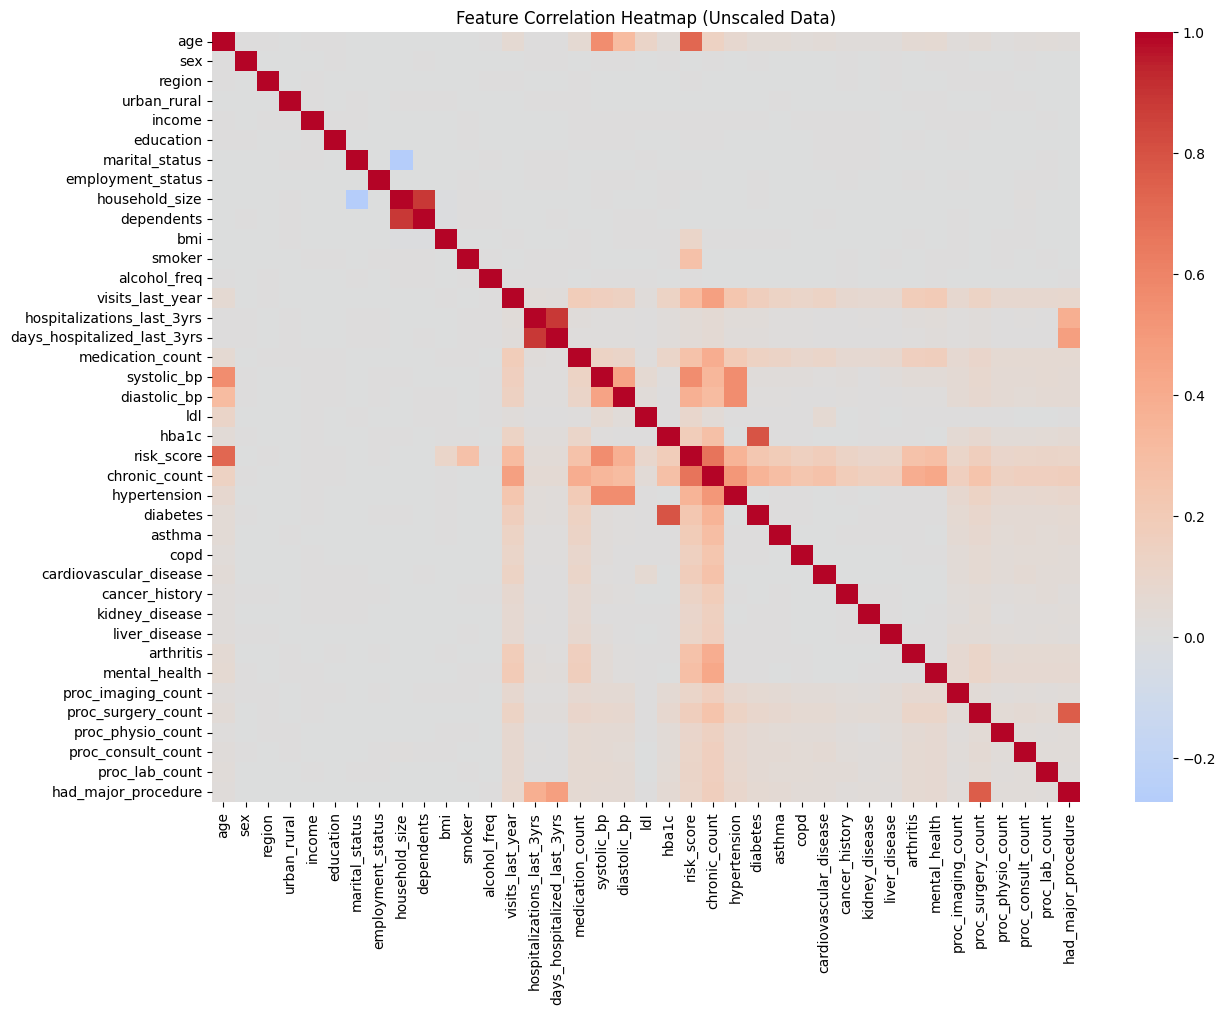

In [2]:
file_path = "medical_insurance.csv"  # Change this to your actual file name
df = pd.read_csv(file_path)
df.drop(columns=['person_id'], inplace=True)
print("\nMissing Values (before encoding):\n", df.isnull().sum())
df = df[df['alcohol_freq'].notnull()].copy()

# Drop categories that aren't related to demographics or health
df = df.drop(columns=['is_high_risk','annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'total_claims_paid', 'plan_type', 'network_tier', 'deductible',
                      'copay', 'policy_term_years', 'policy_changes_last_2yrs', 'provider_quality'])

print(df.info())
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\n Categorical Columns Found ({len(categorical_cols)}): {categorical_cols}")


label_mappings = {}  # Dictionary to store code ↔ label mapping

for col in categorical_cols:
    df[col] = df[col].astype('category')                 # Convert to category type

# Fixing order of columns
    # Reorder education column from lowest to highest
    if col == 'education':
        correct_order = ['No HS', 'HS', 'Some College', 'Bachelors', 'Masters', 'Doctorate']
        df[col] = df[col].cat.reorder_categories(correct_order)
        
    # Reverse only for the smoker column
    if col == 'smoker':  
        df[col] = df[col].cat.reorder_categories(df[col].cat.categories[::-1])
    
    label_mappings[col] = dict(enumerate(df[col].cat.categories))  # Save mapping
    df[col] = df[col].cat.codes                          # Replace labels with codes


for col, mapping in label_mappings.items():
    print(f" Column: {col}")
    for code, label in mapping.items():
        print(f" {code} → {label}")
    print("-" * 40)



plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Unscaled Data)")
plt.show()


Correlation of all features with 'risk_score':

risk_score                     1.000000
age                            0.722978
chronic_count                  0.666335
systolic_bp                    0.555488
diastolic_bp                   0.380324
hypertension                   0.349195
visits_last_year               0.310541
mental_health                  0.288653
smoker                         0.264857
medication_count               0.263951
arthritis                      0.261768
diabetes                       0.230622
asthma                         0.194654
hba1c                          0.180705
cardiovascular_disease         0.174336
proc_surgery_count             0.166397
copd                           0.150540
cancer_history                 0.116960
proc_lab_count                 0.113647
had_major_procedure            0.110706
bmi                            0.107358
proc_imaging_count             0.106453
proc_consult_count             0.105439
liver_disease                  0

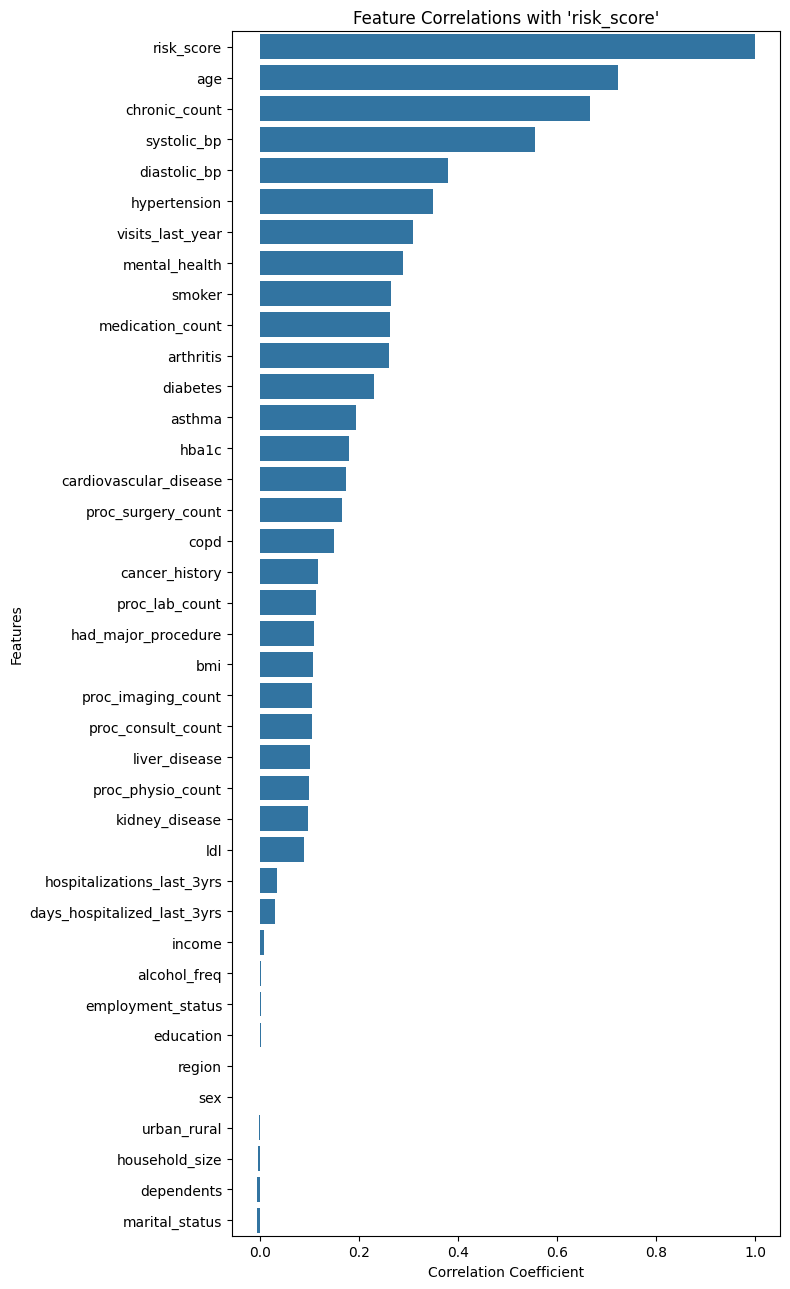

In [3]:
correlations = df.corr()['risk_score'].sort_values(ascending=False)

# Print all correlation values
print("Correlation of all features with 'risk_score':\n")
print(correlations)

corr_df = correlations.reset_index()
corr_df.columns = ['Feature', 'Correlation_with_risk_score']


plt.figure(figsize=(8, len(corr_df) / 3))
sns.barplot(x='Correlation_with_risk_score', y='Feature', data=corr_df)
plt.title("Feature Correlations with 'risk_score'")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



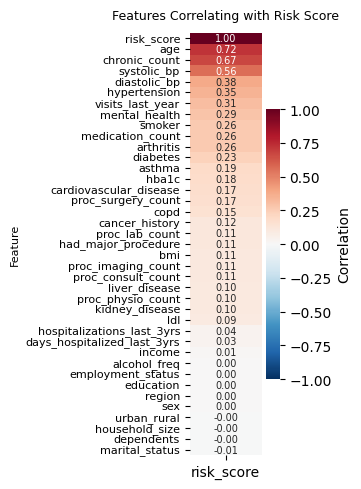

In [12]:
#figure 1 - Correlation heatmap
plt.figure(figsize=(3.5, 5))

corr = df.corr()[['risk_score']].sort_values(by='risk_score', ascending=False)

heatmap = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt='.2f', #correlation to two decimals
    cmap='RdBu_r',  # Red-Blue colormap (red=positive, blue=negative)
    cbar_kws={'label': 'Correlation'},
    annot_kws={'fontsize': 7}
)

# Force all labels to appear
heatmap.set_yticks(np.arange(len(corr.index)) + 0.5)
heatmap.set_yticklabels(corr.index, rotation=0, fontsize=8)

heatmap.set_title('Features Correlating with Risk Score', fontsize=9, pad=10)
heatmap.set_xlabel('')
heatmap.set_ylabel('Feature', fontsize=8)
plt.tight_layout()

plt.savefig('fig_1_risk_score_correlation.png', dpi=600, bbox_inches='tight')
plt.show()


In [13]:
#Ridge and Lasso WITH AGE

X = df.drop(columns=['risk_score'])
y = df['risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80/20- train/test


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #to choose the best alpha fro both regression

ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_scaled, y_train)

best_ridge_alpha = ridge_cv.alpha_
ridge_coefs = pd.Series(ridge_cv.coef_, index=X.columns).sort_values(key=abs, ascending=False)

# Ridge
ridge_pred = ridge_cv.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

print(f"Best Ridge α: {best_ridge_alpha}")
print(f"Ridge R²: {ridge_r2:.4f}, RMSE: {ridge_rmse:.4f}\n")


lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

best_lasso_alpha = lasso_cv.alpha_
lasso_coefs = pd.Series(lasso_cv.coef_, index=X.columns).sort_values(key=abs, ascending=False)

# Lasso
lasso_pred = lasso_cv.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

print(f"Best Lasso α: {best_lasso_alpha}")
print(f"Lasso R²: {lasso_r2:.4f}, RMSE: {lasso_rmse:.4f}\n")

coef_comparison = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs
}).sort_values(by='Lasso', key=abs, ascending=False)

print("Ridge vs Lasso Coefficients:")
print(coef_comparison)


print("\n Best Regularization Parameters:")
print(f"Ridge α = {best_ridge_alpha}")
print(f"Lasso α = {best_lasso_alpha}")



Best Ridge α: 10.0
Ridge R²: 0.9343, RMSE: 0.0644

Best Lasso α: 0.001
Lasso R²: 0.9340, RMSE: 0.0646

Ridge vs Lasso Coefficients:
                                Ridge     Lasso
age                          0.161837  0.160961
chronic_count                0.072099  0.143251
smoker                       0.068585  0.067567
bmi                          0.026641  0.025653
hypertension                 0.037905  0.001360
diastolic_bp                 0.000702  0.000377
had_major_procedure          0.007129  0.000185
mental_health                0.030919  0.000049
cancer_history               0.012433 -0.000000
proc_physio_count           -0.000041  0.000000
medication_count            -0.000729 -0.000000
proc_consult_count           0.000022  0.000000
proc_imaging_count          -0.000082  0.000000
proc_lab_count               0.000092  0.000000
proc_surgery_count          -0.006093 -0.000000
liver_disease                0.009835 -0.000000
region                       0.000692  0.000000
sex 

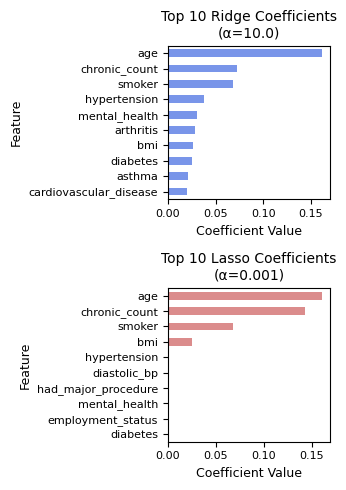

In [14]:
#Figure 2 : Comparing Ridge and Lasso Coeffs with Age

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 5))  # Single-column, stacked
# Ridge
ridge_coefs[:10].plot(kind='barh', color='royalblue', alpha=0.7, ax=ax1)
ax1.set_title(f"Top 10 Ridge Coefficients\n(α={best_ridge_alpha})", fontsize=10)
ax1.set_xlabel("Coefficient Value", fontsize=9)
ax1.set_ylabel("Feature", fontsize=9)
ax1.invert_yaxis()
ax1.tick_params(labelsize=8)

# Lasso
lasso_coefs[:10].plot(kind='barh', color='indianred', alpha=0.7, ax=ax2)
ax2.set_title(f"Top 10 Lasso Coefficients\n(α={best_lasso_alpha})", fontsize=10)
ax2.set_xlabel("Coefficient Value", fontsize=9)
ax2.set_ylabel("Feature", fontsize=9)
ax2.invert_yaxis()
ax2.tick_params(labelsize=8)

plt.tight_layout()

# Save at high resolution for IEEE paper
plt.savefig('fig_2_ridge_lasso_comparison_with_age.png', dpi=600, bbox_inches='tight')
plt.show()

In [13]:
#Ridge and Lasso WITHOUT AGE

X = df.drop(columns=['risk_score','age'])
y = df['risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80/20- train/test


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #to choose the best alpha fro both regression

ridge_cv = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_cv.fit(X_train_scaled, y_train)

best_ridge_alpha = ridge_cv.alpha_
ridge_coefs = pd.Series(ridge_cv.coef_, index=X.columns).sort_values(key=abs, ascending=False)

# Ridge
ridge_pred = ridge_cv.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

print(f"Best Ridge α: {best_ridge_alpha}")
print(f"Ridge R²: {ridge_r2:.4f}, RMSE: {ridge_rmse:.4f}\n")


lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

best_lasso_alpha = lasso_cv.alpha_
lasso_coefs = pd.Series(lasso_cv.coef_, index=X.columns).sort_values(key=abs, ascending=False)

# Lasso
lasso_pred = lasso_cv.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

print(f"Best Lasso α: {best_lasso_alpha}")
print(f"Lasso R²: {lasso_r2:.4f}, RMSE: {lasso_rmse:.4f}\n")

coef_comparison = pd.DataFrame({
    'Ridge': ridge_coefs,
    'Lasso': lasso_coefs
}).sort_values(by='Lasso', key=abs, ascending=False)

print("Ridge vs Lasso Coefficients:")
print(coef_comparison)


print("\n Best Regularization Parameters:")
print(f"Ridge α = {best_ridge_alpha}")
print(f"Lasso α = {best_lasso_alpha}")



Best Ridge α: 10.0
Ridge R²: 0.7053, RMSE: 0.1364

Best Lasso α: 0.001
Lasso R²: 0.7054, RMSE: 0.1364

Ridge vs Lasso Coefficients:
                                Ridge     Lasso
chronic_count                0.058441  0.152515
systolic_bp                  0.111324  0.109616
hypertension                -0.028144 -0.072240
smoker                       0.067986  0.066938
diastolic_bp                 0.040598  0.038741
bmi                          0.026809  0.025809
ldl                          0.009447  0.008678
mental_health                0.042770  0.002458
arthritis                    0.038326  0.000895
region                       0.001568  0.000512
cardiovascular_disease       0.027018  0.000458
had_major_procedure          0.007142  0.000397
asthma                       0.028786  0.000354
diabetes                     0.034492  0.000212
proc_lab_count               0.000965  0.000077
proc_physio_count           -0.001228 -0.000055
marital_status               0.000361  0.000000
proc

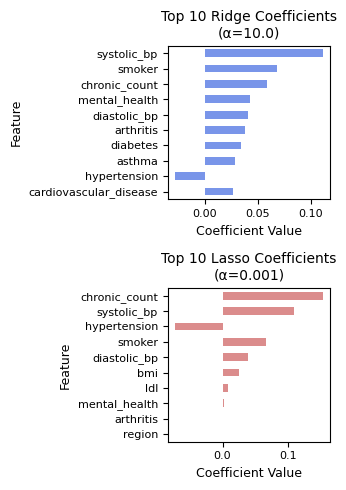

In [16]:
#Figure 3 : Comparing Ridge and Lasso Coeffs without Age

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.5, 5))  # Single-column, stacked
# Ridge
ridge_coefs[:10].plot(kind='barh', color='royalblue', alpha=0.7, ax=ax1)
ax1.set_title(f"Top 10 Ridge Coefficients\n(α={best_ridge_alpha})", fontsize=10)
ax1.set_xlabel("Coefficient Value", fontsize=9)
ax1.set_ylabel("Feature", fontsize=9)
ax1.invert_yaxis()
ax1.tick_params(labelsize=8)

# Lasso
lasso_coefs[:10].plot(kind='barh', color='indianred', alpha=0.7, ax=ax2)
ax2.set_title(f"Top 10 Lasso Coefficients\n(α={best_lasso_alpha})", fontsize=10)
ax2.set_xlabel("Coefficient Value", fontsize=9)
ax2.set_ylabel("Feature", fontsize=9)
ax2.invert_yaxis()
ax2.tick_params(labelsize=8)

plt.tight_layout()

# Save at high resolution for IEEE paper
plt.savefig('fig_3_ridge_lasso_comparison_without_age.png', dpi=600, bbox_inches='tight')
plt.show()

R²: 1.0000
RMSE: 0.0013


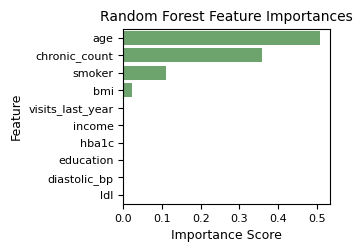

In [21]:
#Random Forest WITH AGE

# Define features and target
X = df.drop(columns=['risk_score'])
y = df['risk_score']



# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate performance
y_pred = rf.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Figure 4 - Random Forest WITH age

plt.figure(figsize=(3.5, 2.625))  # Single-column width for IEEE

sns.barplot(x=importances[:10], y=importances.index[:10], color='forestgreen', alpha=0.7)
plt.title("Random Forest Feature Importances", fontsize=10)
plt.xlabel("Importance Score", fontsize=9)
plt.ylabel("Feature", fontsize=9)
plt.tick_params(labelsize=8)
plt.tight_layout()

# Save at high resolution for IEEE paper
plt.savefig('fig_4_random_forest_importances_withage.png', dpi=600, bbox_inches='tight')
plt.show()


R²: 0.7463
RMSE: 0.1265


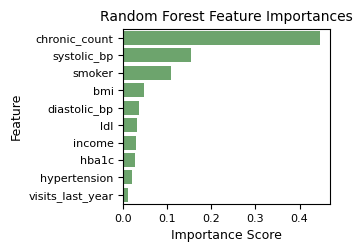

In [20]:
#Random Forest WITHOUT AGE

# Define features and target
X = df.drop(columns=['risk_score','age'])
y = df['risk_score']



# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate performance
y_pred = rf.predict(X_test)
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Figure 5 - Random Forest WITHOUT age

plt.figure(figsize=(3.5, 2.625))  # Single-column width for IEEE

sns.barplot(x=importances[:10], y=importances.index[:10], color='forestgreen', alpha=0.7)
plt.title("Random Forest Feature Importances", fontsize=10)
plt.xlabel("Importance Score", fontsize=9)
plt.ylabel("Feature", fontsize=9)
plt.tick_params(labelsize=8)
plt.tight_layout()

# Save at high resolution for IEEE paper
plt.savefig('fig_5_random_forest_importances_withoutage.png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
iso = IsolationForest(
    n_estimators=200,       
    contamination=0.02,     # assuming ~2% of data are anomalies here
    random_state=42,
    n_jobs=-1            
)

df['anomaly'] = iso.fit_predict(X)


# -1 = anomaly (outlier)
#  1 = normal
anomalies = df[df['anomaly'] == -1]
normals = df[df['anomaly'] == 1]

print(f"Total records: {len(df)}")
print(f"Anomalies detected: {len(anomalies)} ({len(anomalies)/len(df)*100:.2f}%)")

print("\n Sample anomaly records:")
print(anomalies.head())

# just for real world interpretation #could've viasualized any other features pair
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='risk_score',
    y='annual_medical_cost',
    data=df,
    hue='anomaly',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title("Isolation Forest - Detected Anomalies (Red = Outliers)")
plt.xlabel("Risk Score")
plt.ylabel("Annual Medical Cost")
plt.legend(title='Status', labels=['Normal', 'Anomaly'])
plt.tight_layout()
plt.show()

